<h1> Assingment_Computer_Visison

In [1]:
!pip install transformers
!pip install datasets
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00


In [24]:
from IPython.display import Image as Img
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import zipfile
import os
import re
import pandas as pd

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the folder you want to access
folder_path = 'drive/MyDrive/Images.zip'

Mounted at /content/drive


<h2> Pre-Processing

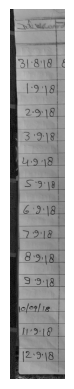

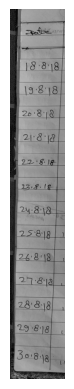

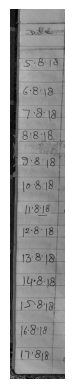

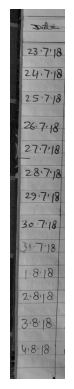

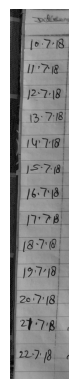

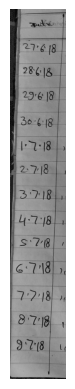

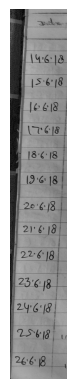

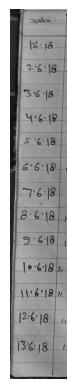

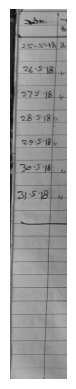

In [4]:
# Extract the zipped file
with zipfile.ZipFile(folder_path, 'r') as zip_ref:
    zip_ref.extractall('/')

# Assuming the first file in the zip is your image.
# If there are multiple files, you may need to loop through them.
for i in range(len(zip_ref.namelist())):
    filename = '/' + zip_ref.namelist()[i]

    img = cv2.imread(filename, cv2.IMREAD_COLOR)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    dilated1 = cv2.GaussianBlur(gray, (5, 5), 0)
    dilated = cv2.cvtColor(dilated1, cv2.IMREAD_COLOR)

    # Ensure the image was read correctly
    if img is None:
        print("Error reading the image")
        exit()

    # Get the width of the image
    width = dilated.shape[1]

    # Crop the image
    cropped = dilated[:, :width//9]

    # Create a new directory for cropped images if it doesn't exist
    cropped_directory = 'Cropped_Images'
    if not os.path.exists(cropped_directory):
        os.makedirs(cropped_directory)

    # Save the cropped image in the new directory
    output_filename = os.path.join(cropped_directory, 'Cropped_' + filename.split('/')[-1])
    cv2.imwrite(output_filename, cropped)

    # Display the cropped image using matplotlib
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for proper display
    plt.axis('off')
    plt.show()


In [5]:
source_folder = 'Cropped_Images'
output_folder = 'Pre_Processed_Images'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List all files in the source folder
image_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

for image_file in image_files:
    # Open the image
    img_path = os.path.join(source_folder, image_file)
    img = Image.open(img_path)

    # Enhance the brightness
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(1.5)

    # Save the enhanced image to the output folder
    output_path = os.path.join(output_folder, image_file)

    img.save(output_path)

print("Brightness enhancement applied to all images.")


Brightness enhancement applied to all images.


Visualizing the Resultant Image

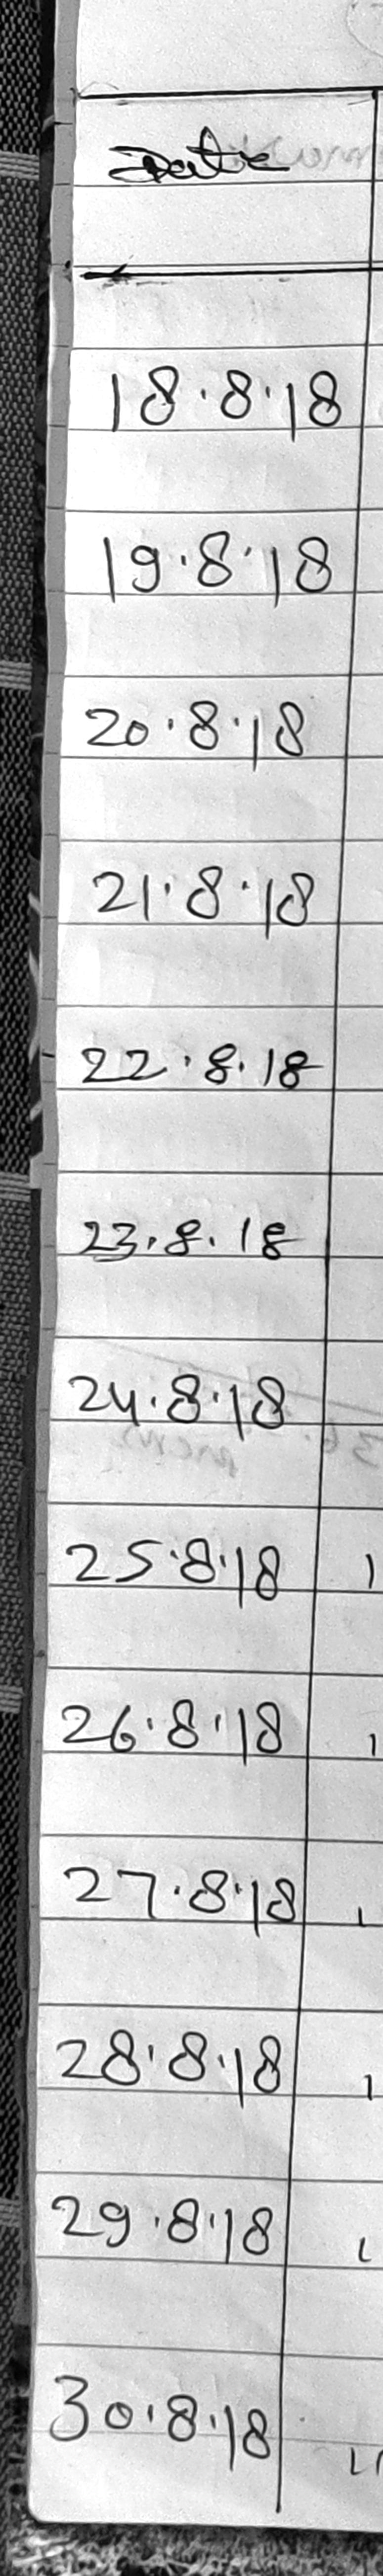

In [6]:
from IPython.display import Image as Img
Img("Pre_Processed_Images/Cropped_IMG2.jpg")

Loading PreTrained Model Donut from HuggingFace

In [7]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Done")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Done


Generating OutPuts on our Image using PreTrained Model

In [8]:
source_folder = 'Pre_Processed_Images'

# List all files in the source folder
image_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

sequences_list = []

for image_file in image_files:
    # Open the image
    img_path = os.path.join(source_folder, image_file)
    image = Image.open(img_path)

    # Prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    pixel_values = processor(image, return_tensors="pt").pixel_values


    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    sequence = processor.batch_decode(outputs.sequences)[0]
    print(sequence)
    sequences_list.append(sequence)

<s_cord-v2><s_menu><s_nm> 25~5218</s_unitprice><s_cnt> 2</s_cnt><s_price> 26 518</s_price><s_sub><s_nm> 27 18<sep/><s_nm> 28 5 18</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price> 29 5 18</s_subtotal_price><s_tax_price> 30 5 18<sep/> 31.518</s_tax_price></s_sub_total><s_total><s_total_price> 31.518</s_total_price></s_total></s>
<s_cord-v2><s_menu><s_nm> 16.18</s_nm><s_unitprice> 16.18</s_unitprice><s_cnt> 2.6 18</s_cnt><s_price> 16 18</s_price><sep/><s_nm> 4.6 18</s_nm><s_unitprice> 5.6 18</s_unitprice><s_cnt> 6.18</s_cnt><s_price> 6.18</s_price><sep/><s_nm> 8.6 18</s_nm><s_unitprice> 9.618</s_unitprice><s_cnt> 1. 4 1. 1</s_cnt><s_price> 8.618</s_price><sep/><s_nm> 12.618</s_unitprice><s_cnt> 1.</s_cnt><s_price> 12.618</s_price></s_menu><s_sub_total><s_subtotal_price> 13.618</s_subtotal_price><s_tax_price> 13.618</s_tax_price></s_sub_total><s_total><s_total_price> 13.618</s_total_price></s_total></s>
<s_cord-v2><s_menu><s_nm> 15 618<sep/> 1 6 18<sep/> 1 6 18<sep/><s_nm> 18 6 18<se

Fetching the actual content/Dates.

In [10]:
contents = []
# Use a regex to find all content between tags
for sequence in sequences_list:
    content_list = re.findall(r'>\s*([^<]+)\s*<', sequence)
    contents.append(content_list)
# Print the list
print(contents)

[['25~5218', '2', '26 518', '27 18', '28 5 18', '29 5 18', '30 5 18', '31.518', '31.518'], ['16.18', '16.18', '2.6 18', '16 18', '4.6 18', '5.6 18', '6.18', '6.18', '8.6 18', '9.618', '1. 4 1. 1', '8.618', '12.618', '1.', '12.618', '13.618', '13.618', '13.618'], ['15 618', '1 6 18', '1 6 18', '18 6 18', '19 6 18', '19 6 18', '20 6 18', '21,618', '22.618', '22.618', '23,618', '25.618', '26.618'], ['10 718', '12 718', '12 718', '13 718', '14 718', '15 718', '16 718', '17,78', '19,718', '27,718'], ['18 818', '19 818', '20 8 18', '21 8 18', '22,818', '23,818', '24 8 18', '24 818', '25.818', '26.818', '27 818', '28.818', '29.818', '30.818'], ["27'618", "28'618", "29'618", '30.618', "29'618", '1 7 18', '2,718', '3 718', '2,718', 'S 718', '718', '4 718', '7,718', '8.718'], ['6,818', '818', '7 8 18', '818', '9,818', '10,818', '11,818', '11,818', '12.818', '13 818', '14 818', '818', '17.818'], ['23,718', '24,718', '27,718', '26 748', '27 718', '28,718', '30 748', '31,718', '818', '1', '3,818', 

In [11]:
data_list = contents

# Preprocess data: Removing Dates of length 1
data_list = [sublist for sublist in data_list if len(sublist) > 1]
for i in range(len(data_list)):
    data_list[i] = [item for item in data_list[i] if len(item) > 1]

In [12]:
data_list

[['25~5218',
  '26 518',
  '27 18',
  '28 5 18',
  '29 5 18',
  '30 5 18',
  '31.518',
  '31.518'],
 ['16.18',
  '16.18',
  '2.6 18',
  '16 18',
  '4.6 18',
  '5.6 18',
  '6.18',
  '6.18',
  '8.6 18',
  '9.618',
  '1. 4 1. 1',
  '8.618',
  '12.618',
  '1.',
  '12.618',
  '13.618',
  '13.618',
  '13.618'],
 ['15 618',
  '1 6 18',
  '1 6 18',
  '18 6 18',
  '19 6 18',
  '19 6 18',
  '20 6 18',
  '21,618',
  '22.618',
  '22.618',
  '23,618',
  '25.618',
  '26.618'],
 ['10 718',
  '12 718',
  '12 718',
  '13 718',
  '14 718',
  '15 718',
  '16 718',
  '17,78',
  '19,718',
  '27,718'],
 ['18 818',
  '19 818',
  '20 8 18',
  '21 8 18',
  '22,818',
  '23,818',
  '24 8 18',
  '24 818',
  '25.818',
  '26.818',
  '27 818',
  '28.818',
  '29.818',
  '30.818'],
 ["27'618",
  "28'618",
  "29'618",
  '30.618',
  "29'618",
  '1 7 18',
  '2,718',
  '3 718',
  '2,718',
  'S 718',
  '718',
  '4 718',
  '7,718',
  '8.718'],
 ['6,818',
  '818',
  '7 8 18',
  '818',
  '9,818',
  '10,818',
  '11,818',
  '11

This is the actual Dates which our model Outputs which is not that bad as Mostly Punctuations is causing issue so if we can finetune it then we could achive a significant amazing results.

<h3> Post Processing

Post Processing the data i.e., dealing wth Punctuations, Missing Value, validating date etc.

In [16]:
last_day = 1
last_month = 1

def format_date(s):
    global last_day, last_month

    # Extract year (last two characters)
    year = s[-2:]

    # Remove year from string
    s = s[:-2]

    # Replace any non-digit characters with spaces
    s = ''.join([c if c.isdigit() else ' ' for c in s])

    # Split by spaces to get date and month
    parts = s.split()

    # Handle date and month extraction based on available parts
    if len(parts) == 1:
        # If the original string had a punctuation before the number, it's a date, not a month
        if not s[0].isdigit():
            day = int(parts[0])
            month = last_month
        else:
            day = last_day + 1
            month = int(parts[0])
    elif len(parts) == 2:
        day, month = map(int, parts)
    else:
        return None

    # Discard if day > 31 or month > 12
    if day > 31 or month > 12:
        return None

    # Update the reference day and month
    last_day, last_month = day, month

    return f"{day:02d}-{month:02d}-{year}"

In [20]:
formatted_data = []
for sublist in data_list:
    formatted_sublist = []
    for s in sublist:
        formatted_date = format_date(s)
        if formatted_date and formatted_date not in formatted_sublist:
            formatted_sublist.append(formatted_date)
    if formatted_sublist:
        formatted_data.append(formatted_sublist)

In [21]:
formatted_data

[['26-05-18', '28-05-18', '29-05-18', '30-05-18', '31-05-18'],
 ['02-06-18',
  '04-06-18',
  '05-06-18',
  '06-06-18',
  '07-06-18',
  '08-06-18',
  '09-06-18',
  '12-06-18',
  '13-06-18'],
 ['15-06-18',
  '01-06-18',
  '18-06-18',
  '19-06-18',
  '20-06-18',
  '21-06-18',
  '22-06-18',
  '23-06-18',
  '25-06-18',
  '26-06-18'],
 ['10-07-18',
  '12-07-18',
  '13-07-18',
  '14-07-18',
  '15-07-18',
  '16-07-18',
  '19-07-18',
  '27-07-18'],
 ['18-08-18',
  '19-08-18',
  '20-08-18',
  '21-08-18',
  '22-08-18',
  '23-08-18',
  '24-08-18',
  '25-08-18',
  '26-08-18',
  '27-08-18',
  '28-08-18',
  '29-08-18',
  '30-08-18'],
 ['27-06-18',
  '28-06-18',
  '29-06-18',
  '30-06-18',
  '01-07-18',
  '02-07-18',
  '03-07-18',
  '07-07-18',
  '08-07-18',
  '04-07-18'],
 ['06-08-18',
  '07-08-18',
  '08-08-18',
  '09-08-18',
  '10-08-18',
  '11-08-18',
  '12-08-18',
  '13-08-18',
  '14-08-18',
  '15-08-18',
  '17-08-18'],
 ['23-07-18',
  '24-07-18',
  '27-07-18',
  '26-07-48',
  '28-07-18',
  '30-0

This is the Post Processed Result We have achived.

Creating Excel Sheet

In [22]:
# Creating Only 1 List with all the dates
formatted_data = []
for sublist in data_list:
    for s in sublist:
        formatted_date = format_date(s)
        if formatted_date and formatted_date not in formatted_data:
            formatted_data.append(formatted_date)

Creating Excel File to Save the Dates

In [25]:
# Convert your list to a DataFrame
df = pd.DataFrame(formatted_data, columns=["Dates"])

# Write the DataFrame to an Excel file
df.to_excel('Output_Dates.xlsx', index=False, engine='openpyxl')

<h2> Summary </h2>

I've explored various optical character recognition tools, including EasyOCR and Tesseract, and experimented with numerous preprocessing techniques. Despite my efforts, I couldn't achieve the desired results. Given the constraints in resources and time, I opted to utilize the pre-trained model 'Donut' from Hugging Face.

Before feeding the images to this model, I preprocessed them using PIL by:

Performing color conversion.<br>
Applying image blurring and color restoration.<br>
Cropping the image.<br>
Brigten the image. <br>
These steps significantly improved the results. I also applied post-processing to further refine the results before presenting the final output.


We can achive some amazing result if we can fintune the above model on some handwritten dates dataset(i.e., DARE).

By :-<br>
Bhavya Bansal <br>
9068136493